# Load old simulation data

In [98]:
# Convenient jupyter setup
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
from typing import Tuple, Callable
import os
import shutil
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sithom.plot import plot_defaults, label_subplots
from sithom.time import timeit
from sithom.place import Point
from sithom.misc import in_notebook
from src.constants import DATA_PATH, FIGURE_PATH
from src.models.generation import ImpactSymmetricTC, Holland08
from src.conversions import si_ify, knots_to_ms
from src.constants import NEW_ORLEANS, DATA_PATH, NO_BBOX

In [100]:
# paths to load data from
paths = [
    "emulation_angle_pos_matern32_variance",
    "emulation_angle_pos_matern32_ent",
    "emulation_angle_pos_Mattern32",
    "emulation_angle_pos_Mattern52",
    "emulation_angle_pos_big",
]

In [101]:
xr.open_dataset(os.path.join(DATA_PATH, "emulation_angle_pos_Mattern32", "data.nc"))

<xarray.Dataset>
Dimensions:   (inum: 100, var: 2, anum: 30)
Coordinates:
  * var       (var) object 'x1' 'x2'
Dimensions without coordinates: inum, anum
Data variables:
    init_x    (inum, var) float32 ...
    init_y    (inum) float64 ...
    active_x  (anum, var) float64 ...
    active_y  (anum) float64 ...
Attributes:
    description:  Training Data

## load initial latin hypercube search from all paths

In [102]:
ds_list = []
for path in paths:
    file_name = os.path.join(DATA_PATH, path, "data.nc")
    path_exists = os.path.exists(file_name)
    if path_exists:
        ds = xr.open_dataset(file_name)
        ds_list.append(ds[["init_x", "init_y"]])
ds_comb = xr.concat(ds_list, dim="inum")
ds_comb

<xarray.Dataset>
Dimensions:  (inum: 600, var: 2)
Coordinates:
  * var      (var) object 'x1' 'x2'
Dimensions without coordinates: inum
Data variables:
    init_x   (inum, var) float32 8.55 2.849 -22.95 -1.519 ... 1.458 -56.7 -1.506
    init_y   (inum) float64 0.8873 2.101 3.554 3.479 ... 6.26 0.628 1.329 4.091
Attributes:
    description:  Training Data

Text(0, 0.5, 'Position [$^{\\circ}$E]')

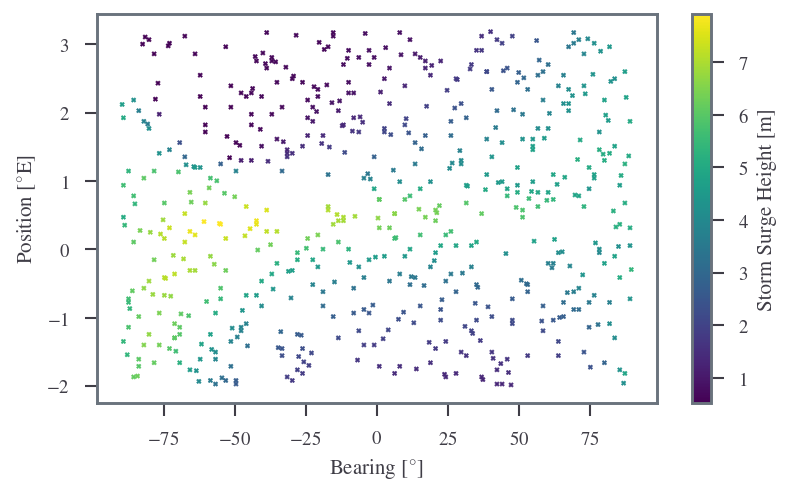

In [103]:
plot_defaults()
plt.scatter(
    ds_comb["init_x"].isel(var=0).values,
    ds_comb["init_x"].isel(var=1).values,
    s=5,
    c=ds_comb["init_y"].values,
)
plt.colorbar(label="Storm Surge Height [m]")
plt.xlabel("Bearing [$^{\circ}$]")
plt.ylabel("Position [$^{\circ}$E]")

In [104]:
os.listdir(os.path.join(DATA_PATH))

['6D_search',
 'sea_surface_temperature.nc',
 'mult3.25',
 'exp_h80',
 'kat_emulation',
 'katex-0.nc',
 'emulation_angle_pos_matern32_variance',
 'kat_xn',
 'katrina-0.nc',
 'mean_sea_level_pressure.nc',
 'kat_rmax',
 'katrina_water_era5.nc',
 'mult0.5',
 'fort.224.nc',
 'significant_height_of_combined_wind_waves_and_swell.nc',
 'emu_ex',
 'katrina_example_input.nc',
 '.DS_Store',
 'Test',
 'mult2.25',
 'emulation_angle_pos_poi',
 'fort.221.nc',
 'IBTrACS.ALL.v04r00.nc',
 'katrina-1.nc',
 'katrina_tides.nc',
 'katex.fort.221',
 'katrina_era5.nc',
 'kat_move_smeared',
 'emulation_angle_pos_mves',
 'katd_h08',
 'lhc',
 'mult1.75',
 'mult1',
 'emu2_ex',
 'mult3.5',
 'kate_h08',
 'mult0.75',
 '6D_Search_Holdout',
 'fort.218',
 'emu3_ex',
 'kat_pc',
 'kat_angle',
 '10m_v_component_of_wind.nc',
 'emu_angle_position',
 'total_precipitation.nc',
 'fort.221',
 'emulation_angle_pos_Mattern52',
 '6DSearch',
 'fort.217',
 'emulation_angle_pos_big',
 'mult3.75',
 'README.md',
 'IBTrACS_gom_landings

In [105]:
ds_comb["init_y"].max(dim="inum")

<xarray.DataArray 'init_y' ()>
array(7.91581181)

## load active learning data points

In [106]:
ds_list = []
for path in paths:
    file_name = os.path.join(DATA_PATH, path, "data.nc")
    path_exists = os.path.exists(file_name)
    if path_exists:
        ds = xr.open_dataset(file_name)
        ds_list.append(ds[["active_x", "active_y"]])
ds_act = xr.concat(ds_list, dim="anum")
ds_act

<xarray.Dataset>
Dimensions:   (anum: 190, var: 2)
Coordinates:
  * var       (var) object 'x1' 'x2'
Dimensions without coordinates: anum
Data variables:
    active_x  (anum, var) float64 90.0 3.2 -57.04 3.2 ... -0.1284 -82.82 -0.223
    active_y  (anum) float64 4.272 0.5898 4.822 1.288 ... 5.153 4.085 5.954
Attributes:
    description:  Training Data

Text(0, 0.5, 'Position [$^{\\circ}$E]')

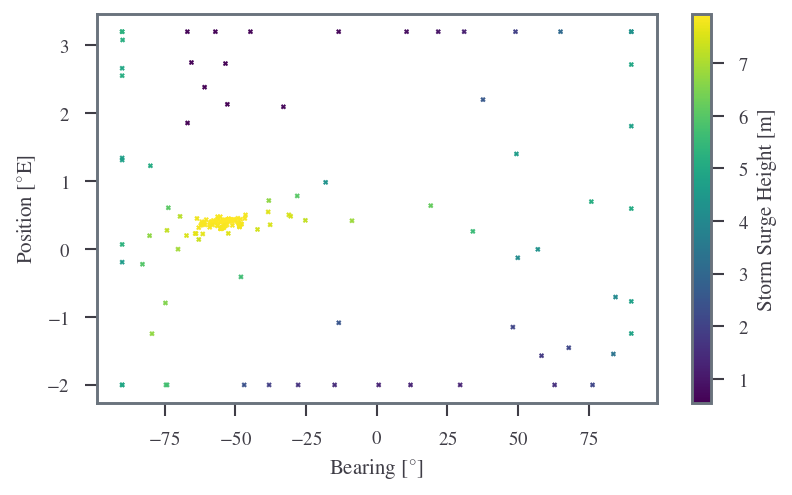

In [107]:
plot_defaults()
plt.scatter(
    ds_act["active_x"].isel(var=0).values,
    ds_act["active_x"].isel(var=1).values,
    s=5,
    c=ds_act["active_y"].values,
)
plt.colorbar(label="Storm Surge Height [m]")
plt.xlabel("Bearing [$^{\circ}$]")
plt.ylabel("Position [$^{\circ}$E]")

In [108]:
ds_act["active_y"].max(dim="anum")

<xarray.DataArray 'active_y' ()>
array(7.94099995)

## Plot all data points together

Text(0, 0.5, 'Position [$^{\\circ}$E]')

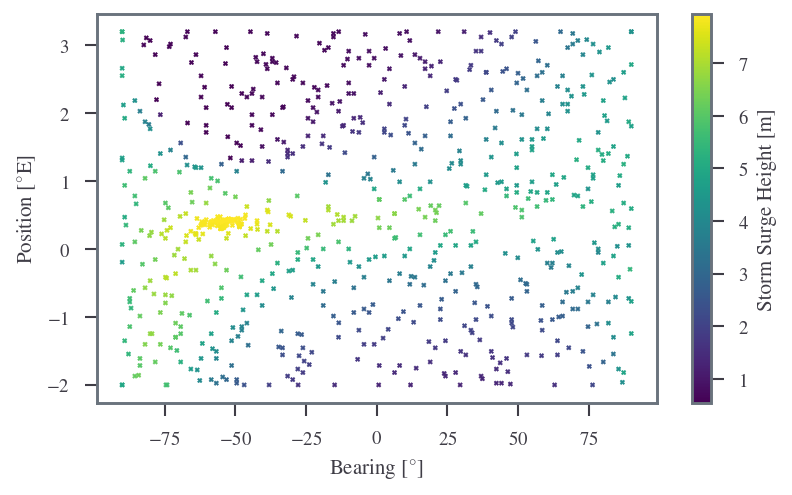

In [109]:
plot_defaults()
plt.scatter(
    ds_comb["init_x"].isel(var=0).values,
    ds_comb["init_x"].isel(var=1).values,
    s=5,
    c=ds_comb["init_y"].values,
)
plt.scatter(
    ds_act["active_x"].isel(var=0).values,
    ds_act["active_x"].isel(var=1).values,
    s=5,
    c=ds_act["active_y"].values,
)
plt.colorbar(label="Storm Surge Height [m]")
plt.xlabel("Bearing [$^{\circ}$]")
plt.ylabel("Position [$^{\circ}$E]")

## Divide the initial data into training and test sets

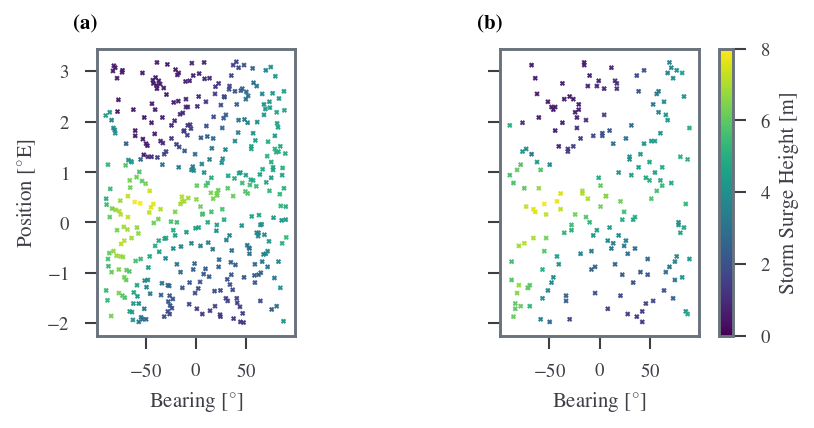

In [110]:
x_data = ds_comb.init_x.values
y_data = ds_comb.init_y.values.reshape((600, 1))
in_full_x = x_data[:-200]
in_full_y = y_data[:-200]
hold_out_x = x_data[-200:]
hold_out_y = y_data[-200:]

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(6, 3), subplot_kw={'aspect': 50})
plot_defaults()
im = axs[0].scatter(
    in_full_x[:, 0],
    in_full_x[:, 1],
    s=5,
    c=in_full_y[:, 0],
    vmin=0,
    vmax=8,
)
plt.colorbar(im, label="Storm Surge Height [m]")
axs[0].set_xlabel("Bearing [$^{\circ}$]")
axs[0].set_ylabel("Position [$^{\circ}$E]")
axs[1].set_xlabel("Bearing [$^{\circ}$]")
im = axs[1].scatter(
    hold_out_x[:, 0],
    hold_out_x[:, 1],
    s=5,
    c=hold_out_y[:, 0],
    vmin=0,
    vmax=8,
)
label_subplots(axs, override="outside")

In [111]:
anum = np.argmax(ds_act["active_y"].values)
ds_act.isel(anum=anum)

<xarray.Dataset>
Dimensions:   (var: 2)
Coordinates:
  * var       (var) object 'x1' 'x2'
Data variables:
    active_x  (var) float64 -52.67 0.4198
    active_y  float64 7.941
Attributes:
    description:  Training Data

In [112]:
inum = np.argmax(ds_comb["init_y"].values)
ds_comb.isel(inum=inum)

<xarray.Dataset>
Dimensions:  (var: 2)
Coordinates:
  * var      (var) object 'x1' 'x2'
Data variables:
    init_x   (var) float32 -55.35 0.379
    init_y   float64 7.916
Attributes:
    description:  Training Data

## So current best guesses:

Latin hypercube -55.35 $^{\circ}$, 0.379 $^{\circ}$E --> 7.916 m

Active Learning -52.67 $^{\circ}$, 0.4198 $^{\circ}$E --> 7.941 m


## Verification Curve

In [113]:
ds_comb

<xarray.Dataset>
Dimensions:  (inum: 600, var: 2)
Coordinates:
  * var      (var) object 'x1' 'x2'
Dimensions without coordinates: inum
Data variables:
    init_x   (inum, var) float32 8.55 2.849 -22.95 -1.519 ... 1.458 -56.7 -1.506
    init_y   (inum) float64 0.8873 2.101 3.554 3.479 ... 6.26 0.628 1.329 4.091
Attributes:
    description:  Training Data

In [114]:
from sklearn.model_selection import train_test_split

In [115]:
x_data = ds_comb.init_x.values
y_data = ds_comb.init_y.values.reshape((600, 1))

In [116]:
x_data.shape

(600, 2)

In [117]:
y_data = ds_comb.init_y.values.reshape((600, 1))

In [118]:
y_data.shape

(600, 1)

In [119]:
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.33, random_state=42
)

In [120]:
import GPy
from GPy.kern import Linear, RBF, Matern32, Matern52
from GPy.models import GPRegression

In [121]:
model_gpy = GPRegression(
    x_train,
    y_train,
    RBF(2, 1),
)
model_gpy.optimize()

In [122]:
model_gpy

GP_regression.,value,constraints,priors
rbf.variance,9.723879208156463,+ve,
rbf.lengthscale,2.070306314701057,+ve,
Gaussian_noise.variance,0.3708924867019873,+ve,


In [123]:
y_pred, y_var = model_gpy.predict(x_test)
y_unc = np.sqrt(y_var)

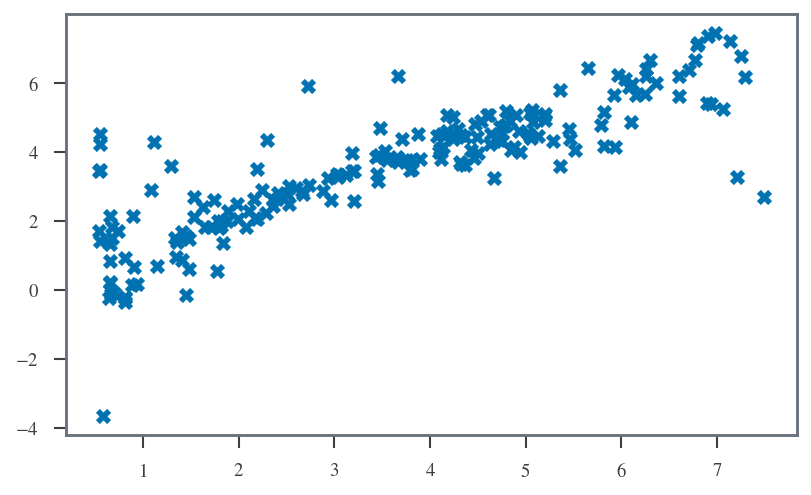

In [124]:
plt.scatter(y_test, y_pred)

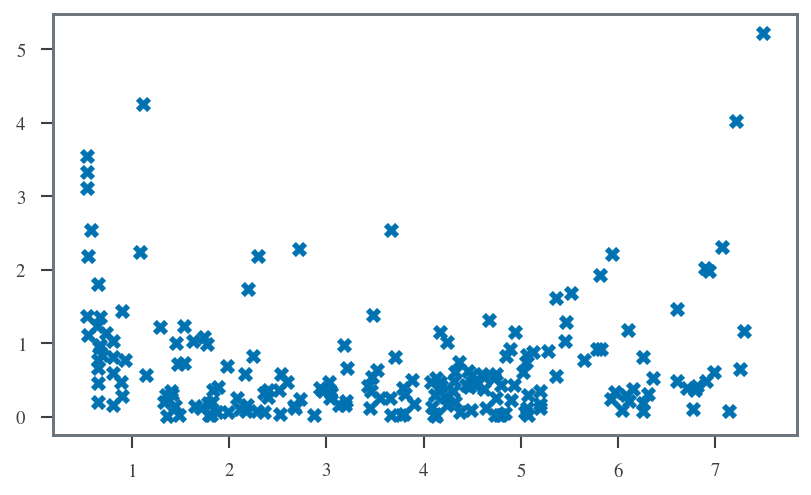

In [125]:
plt.scatter(y_test, np.abs(y_pred - y_test) / y_unc)

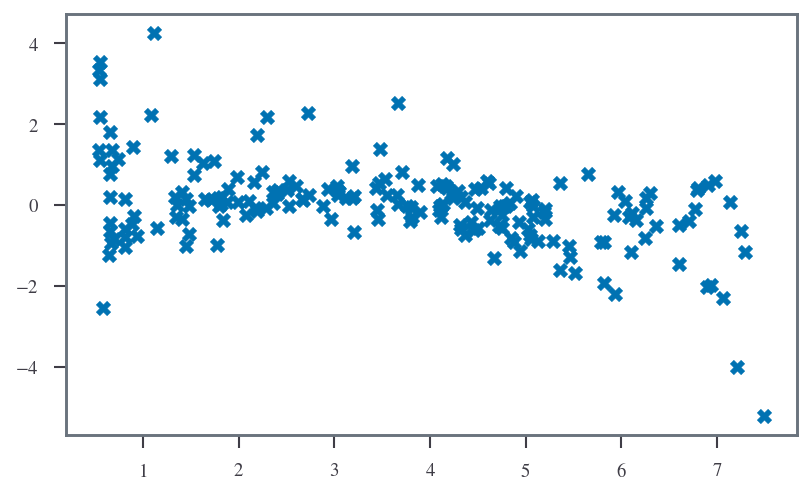

In [126]:
plt.scatter(y_test, (y_pred - y_test) / y_unc)

In [127]:
print( mean_squared_error(y_test, y_pred, squared=False), "m, ", r2_score(y_test, y_pred))

1.050632025314053 m,  0.7056323939427175


In [128]:
import numpy as np
import numpy.ma as ma

In [129]:
ma.corrcoef(y_test, y_pred)

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20,
  dtype=float64)

In [130]:
from sklearn.metrics import r2_score, mean_squared_error

In [131]:
r2_score(y_test, y_pred)

0.7056323939427175

In [132]:
mean_squared_error(y_test, y_pred)

1.1038276526155093

In [133]:
np.sum(np.square((y_pred - y_test) / y_unc)) / len(y_pred)

1.1382338229337388

(array([  1.,   1.,   1.,   8.,  39., 103.,  33.,   7.,   2.,   3.]),
 array([-5.21715208, -4.27029454, -3.32343701, -2.37657948, -1.42972195,
        -0.48286442,  0.46399311,  1.41085065,  2.35770818,  3.30456571,
         4.25142324]),
 <BarContainer object of 10 artists>)

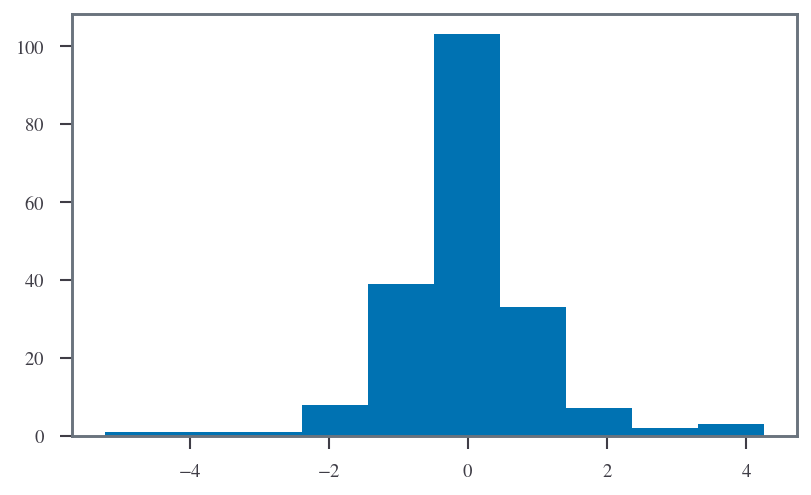

In [134]:
norm_pred = (y_pred - y_test) / y_unc
plt.hist(norm_pred)

In [135]:
np.std(norm_pred)

1.0668475505940105

In [136]:
import scipy

In [137]:
# look at the skewness and kurtosis of the normalized residuals
fp = norm_pred[~np.isnan(norm_pred)]
std = np.std(fp)
mean = np.mean(fp)
skew = scipy.stats.skew(fp)
kurt = scipy.stats.kurtosis(fp) - 3

len(fp), mean, std, skew, kurt

(198,
 0.00837417012601292,
 1.0668475505940105,
 -0.10622636858810543,
 2.1115667335980426)

In [138]:
y_var

array([[0.64247698],
       [0.69876421],
       [0.84743324],
       [0.58265582],
       [0.93953355],
       [0.75942168],
       [0.9549795 ],
       [0.62479807],
       [0.56894886],
       [0.66363571],
       [0.51602173],
       [1.01298515],
       [0.75295538],
       [1.78215887],
       [0.73928093],
       [0.65860237],
       [0.65208509],
       [3.9965025 ],
       [1.21927616],
       [0.61045186],
       [0.64845709],
       [1.50820075],
       [0.63621139],
       [1.09205618],
       [0.81485332],
       [0.70471533],
       [0.65964634],
       [0.99308052],
       [0.54074513],
       [0.70446086],
       [0.61344636],
       [0.82577006],
       [1.03027171],
       [0.55789501],
       [1.32992653],
       [0.64094976],
       [0.81642804],
       [1.01641485],
       [0.49899403],
       [1.2755389 ],
       [0.60116863],
       [0.93036594],
       [0.54811082],
       [1.28485055],
       [1.03792322],
       [0.63175521],
       [0.52584714],
       [0.730

In [139]:
len(y_pred)

198

In [140]:
def r2_func(kernel=RBF, seed=42, test_size=0.33):
    x_train, x_test, y_train, y_test = train_test_split(
        x_data,
        y_data,
        test_size=test_size,
        random_state=seed,
    )
    model_gpy = GPRegression(
        x_train,
        y_train,
        kernel(2, 1),
    )
    model_gpy.optimize()
    y_pred, y_var = model_gpy.predict(x_test)
    # y_unc = np.sqrt(y_pred)
    return r2_score(y_test, y_pred)

In [141]:
r2_func(kernel=Matern52)

0.7653014159830659

In [142]:
r2_func(kernel=Matern32)

0.7846061528100263

In [143]:
r2_func(kernel=RBF)

0.7056323939427175

## Leave some out sweeps

In [144]:
def r2_mean_std(kernel=RBF, test_size=0.33):
    r2_list = []
    for seed in range(0, 10):
        r2_list.append(r2_func(kernel=kernel, seed=seed, test_size=test_size))

    return np.mean(r2_list), np.std(r2_list)


def sweep_test_size(sizes: np.ndarray, kernel=RBF):
    mean_list = []
    std_list = []
    for size in sizes.tolist():
        mean, std = r2_mean_std(kernel=kernel, test_size=size)
        mean_list.append(mean)
        std_list.append(std)
    return np.array(mean_list), np.array(std_list)

In [145]:
sizes = np.array([0.05, 0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5])
rbf_tuple = sweep_test_size(sizes, kernel=RBF)
m32_tuple = sweep_test_size(sizes, kernel=Matern32)
m52_tuple = sweep_test_size(sizes, kernel=Matern52)

## Leave some out sweeps

(0.05, 0.5)

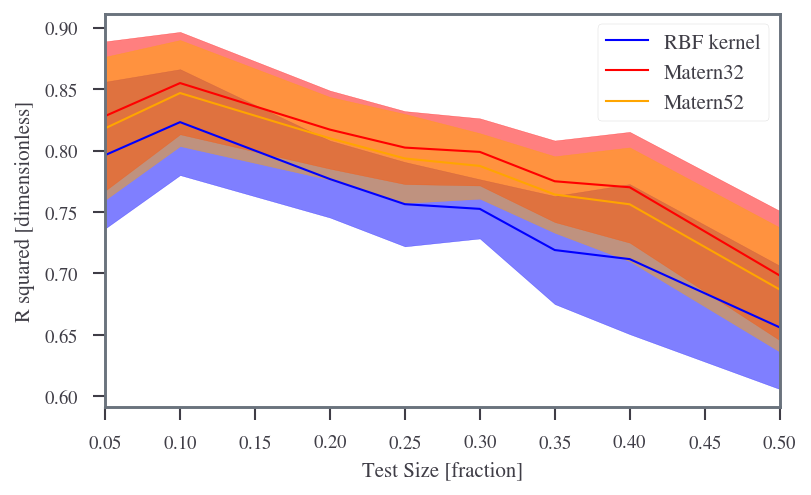

In [146]:
plt.plot(sizes, rbf_tuple[0], label="RBF kernel", color="blue")
plt.fill_between(
    sizes,
    rbf_tuple[0] + rbf_tuple[1],
    rbf_tuple[0] - rbf_tuple[1],
    color="blue",
    alpha=0.5,
)

plt.plot(sizes, m32_tuple[0], label="Matern32", color="red")
plt.fill_between(
    sizes,
    m32_tuple[0] + m32_tuple[1],
    m32_tuple[0] - m32_tuple[1],
    color="red",
    alpha=0.5,
)

plt.plot(sizes, m52_tuple[0], label="Matern52", color="orange")
plt.fill_between(
    sizes,
    m52_tuple[0] + m52_tuple[1],
    m52_tuple[0] - m52_tuple[1],
    color="orange",
    alpha=0.5,
)

plt.legend()
plt.xlabel("Test Size [fraction]")
plt.ylabel("R squared [dimensionless]")
plt.xlim(sizes.min(), sizes.max())

In [147]:
r2_mean_std(test_size=0.5)

(0.6562445519064969, 0.05014888911376649)

In [148]:
sizes.min()

0.05

In [149]:
x_data

array([[  8.550003  ,   2.849     ],
       [-22.95      ,  -1.5189999 ],
       [ 61.65      ,  -0.27099997],
       ...,
       [-45.9       ,   2.238     ],
       [-31.5       ,   1.458     ],
       [-56.7       ,  -1.5059999 ]], dtype=float32)

## Changing the fraction of data input

(0.05, 0.5)

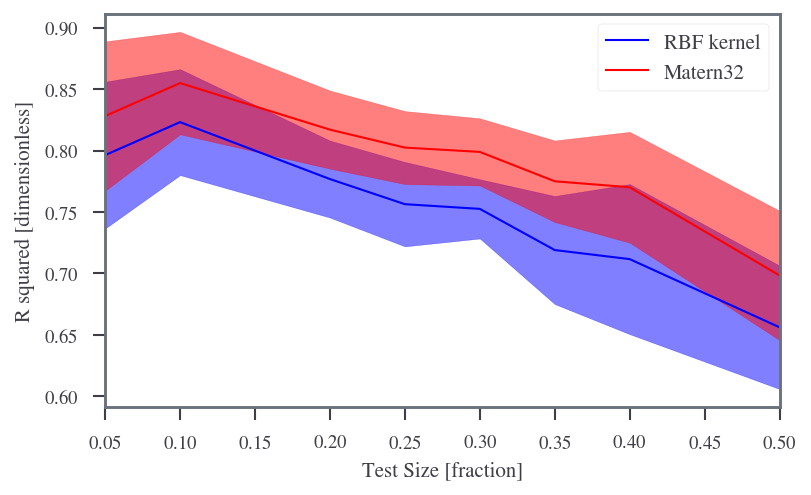

In [150]:
plt.plot(sizes, rbf_tuple[0], label="RBF kernel", color="blue")
plt.fill_between(
    sizes,
    rbf_tuple[0] + rbf_tuple[1],
    rbf_tuple[0] - rbf_tuple[1],
    color="blue",
    alpha=0.5,
)

plt.plot(sizes, m32_tuple[0], label="Matern32", color="red")
plt.fill_between(
    sizes,
    m32_tuple[0] + m32_tuple[1],
    m32_tuple[0] - m32_tuple[1],
    color="red",
    alpha=0.5,
)

plt.legend()
plt.xlabel("Test Size [fraction]")
plt.ylabel("R squared [dimensionless]")
plt.xlim(sizes.min(), sizes.max())

In [151]:
def r2_func_new(kernel=RBF, seed=42, size=0.33):
    in_full_x = x_data[:-200]
    in_full_y = y_data[:-200]
    hold_out_x = x_data[-200:]
    hold_out_y = y_data[-200:]

    x_train, x_test, y_train, y_test = train_test_split(
        in_full_x,
        in_full_y,
        test_size=size,
        random_state=seed,
    )
    model_gpy = GPRegression(
        x_test,
        y_test,
        kernel(2, 1),
    )
    model_gpy.optimize()
    y_pred, y_var = model_gpy.predict(hold_out_x)
    return r2_score(hold_out_y, y_pred)

In [152]:
len(x_data)

600

In [153]:
x_data[:-200].shape

(400, 2)

In [154]:
x_data[-200:].shape

(200, 2)

In [155]:
in_full = x_data[:-200]
hold_out = x_data[-200:]

In [156]:
in_full.shape

(400, 2)

In [157]:
def r2s_maker(sizes, kernel=RBF):
    r2s = []
    for size in sizes.tolist():
        r2s.append(r2_func_new(kernel=kernel, size=size))
    return np.array(r2s)

In [158]:
sizes = np.linspace(0.1, 0.9, num=20)
rbfr2 = r2s_maker(sizes, kernel=RBF)
m32r2 = r2s_maker(sizes, kernel=Matern32)
m52r2 = r2s_maker(sizes, kernel=Matern52)

(0.1, 0.9)

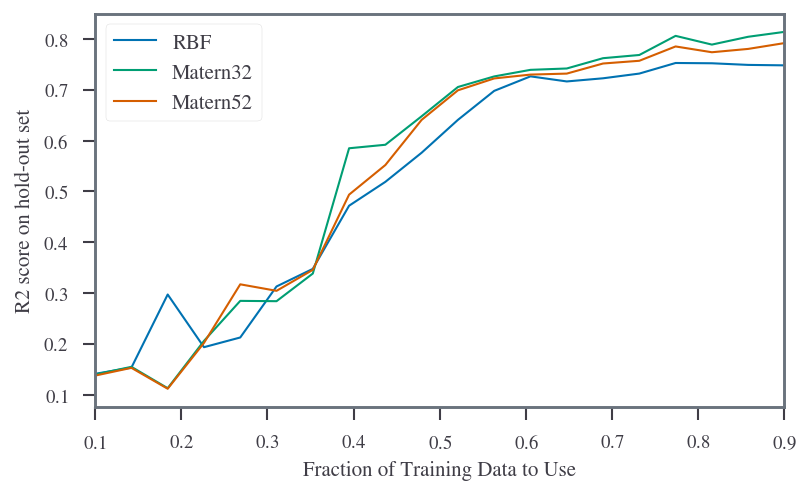

In [159]:
plt.plot(sizes, rbfr2, label="RBF")
plt.plot(sizes, m32r2, label="Matern32")
plt.plot(sizes, m52r2, label="Matern52")
plt.legend()
plt.ylabel("R2 score on hold-out set")
plt.xlabel("Fraction of Training Data to Use")
plt.xlim(sizes.min(), sizes.max())

## Hold one out

In [160]:
in_full_x = x_data[:-200]
in_full_y = y_data[:-200]
hold_out_x = x_data[-200:]
hold_out_y = y_data[-200:]


def y_pred_f(kernel=RBF, seed: int =42, size: int = 399):
    x_train, x_test, y_train, y_test = train_test_split(
        in_full_x,
        in_full_y,
        test_size=size,
        random_state=seed,
    )
    model_gpy = GPRegression(
        x_test,
        y_test,
        kernel(2, 1),
    )
    model_gpy.optimize()
    y_pred, y_var = model_gpy.predict(hold_out_x)
    return y_pred  # , np.std(y_var)

Text(0, 0.5, 'Prediction [m]')

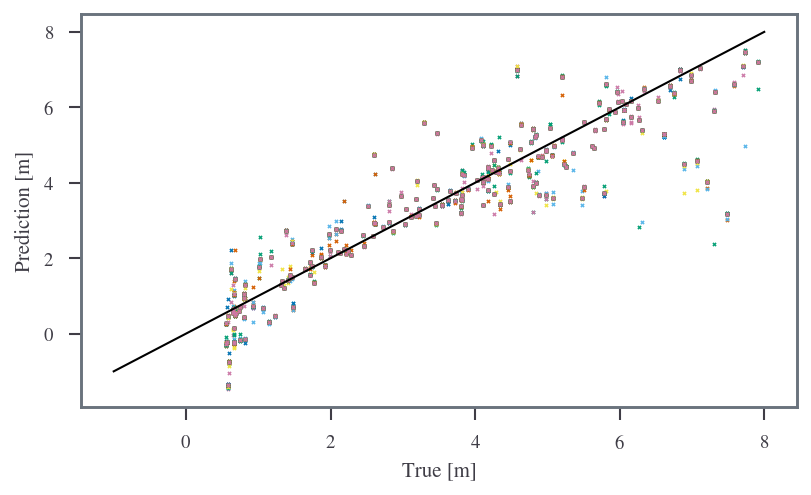

In [161]:
for seed in range(0, 100):
    plt.scatter(hold_out_y, y_pred_f(kernel=Matern32, seed=seed), s=3)

plt.plot([-1, 8], [-1, 8], color="black")
plt.xlabel("True [m]")
plt.ylabel("Prediction [m]")

[0.8340978269305266, 0.78867585960083, 0.8370144051000247, 0.811193608247067, 0.8400756811621863, 0.8298291646844537, 0.8196553732704076, 0.814635745893779, 0.8329746821399494, 0.838042303638177, 0.8339917747444584, 0.8249814801238312, 0.8296212133063303, 0.8381305913083041, 0.8394341826519672, 0.8374704974925467, 0.8302292416817106, 0.8419802430098416, 0.8370751150380424, 0.8291766165386262, 0.8282454302998955, 0.8438237377416575, 0.8263412795351806, 0.8429228961168385, 0.8215624246245462, 0.8321001570540756, 0.8202117976567921, 0.8370146424016793, 0.8259248375528344, 0.836720821619658, 0.831990113682713, 0.8398960371307197, 0.8347293858061913, 0.8249002792068919, 0.8354246600170432, 0.8183797154985241, 0.8416445738532455, 0.838585361674576, 0.8345870634117368, 0.8101666170486944, 0.823172388470436, 0.831783154281856, 0.8355752411951024, 0.8376352512285501, 0.8378815586472754, 0.8378419671183402, 0.8482109687052494, 0.835687620276461, 0.8365614148757773, 0.8387836409702278, 0.82371289

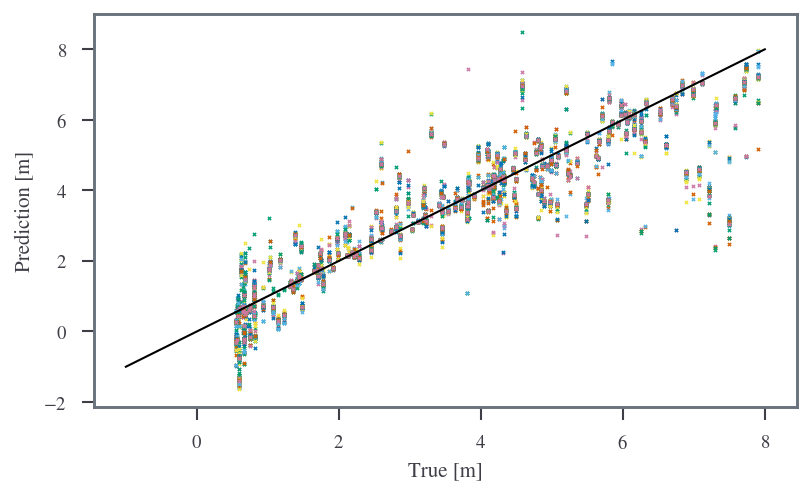

In [162]:
r2_list = []

for seed in range(0, 100):
    y_pre = y_pred_f(kernel=Matern32, seed=seed, size=390)
    plt.scatter(hold_out_y, y_pre, s=3)
    r2_list.append(r2_score(hold_out_y, y_pre))
plt.plot([-1, 8], [-1, 8], color="black")
plt.xlabel("True [m]")
plt.ylabel("Prediction [m]")
print(r2_list)

Text(0, 0.5, 'Frequence')

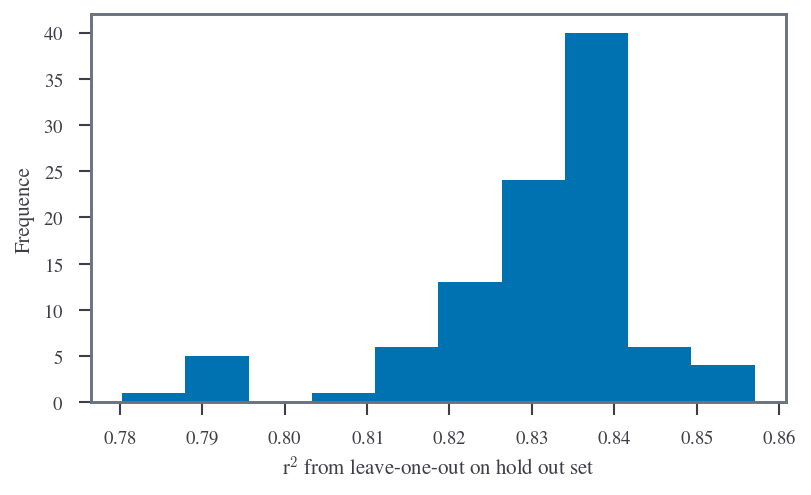

In [163]:
plt.hist(r2_list)
plt.xlabel("r$^{2}$ from leave-one-out on hold out set")
plt.ylabel("Frequency")

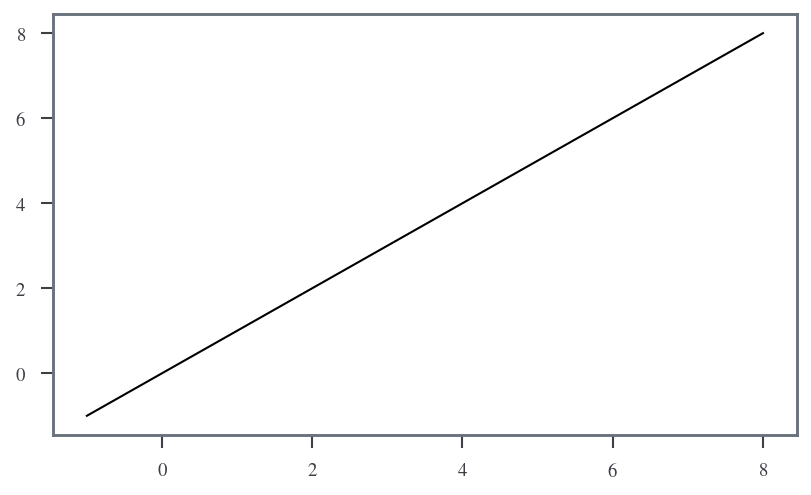

In [164]:
plt.plot([-1, 8], [-1, 8], color="black")

In [165]:
y_pred_l = []
for seed in range(0, 100):
    y_pred_l.append(y_pred_f(kernel=Matern32, seed=seed, size=390))

In [166]:
y_pred_a = np.array(y_pred_l)

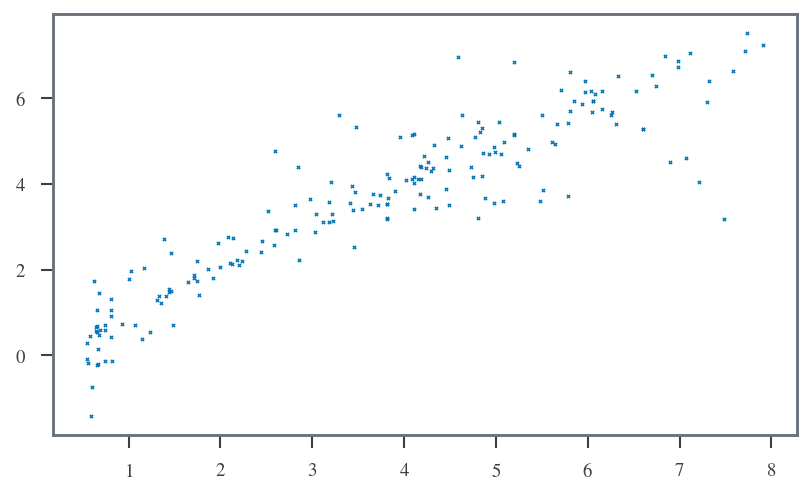

In [167]:
plt.scatter(hold_out_y, y_pred_a[0, :, :], s=3)

array([[0.07803837],
       [0.48597416],
       [0.16446085],
       [0.0961959 ],
       [0.54891112],
       [0.07799687],
       [0.0549381 ],
       [0.00900978],
       [0.0114698 ],
       [0.07686152],
       [0.11209672],
       [0.03112083],
       [0.03585664],
       [0.10203172],
       [0.03552447],
       [0.0531694 ],
       [0.17676295],
       [0.42501671],
       [0.13424781],
       [0.15526211],
       [0.03210091],
       [0.08211992],
       [0.03972423],
       [0.03579664],
       [0.05820179],
       [0.18151994],
       [0.0307382 ],
       [0.47635203],
       [0.03909322],
       [0.22023131],
       [0.09645015],
       [0.01596481],
       [0.06066743],
       [0.41325819],
       [0.11881146],
       [0.11068026],
       [0.12648361],
       [0.08239424],
       [0.09475934],
       [0.03625814],
       [0.06506911],
       [0.01936318],
       [0.14441328],
       [0.31036569],
       [0.07588476],
       [0.19461694],
       [0.05275697],
       [0.154

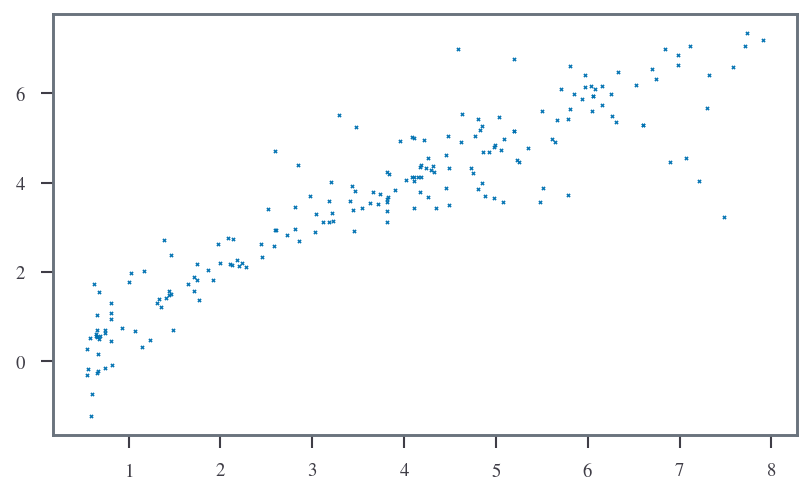

In [168]:
plt.scatter(hold_out_y, y_pred_a[:, :, :].mean(axis=0), s=3)
y_pred_a[:, :, :].std(axis=0)

In [169]:
y_pred_a[:, :, :].std(axis=0)[:, 0].shape

(200,)

 /var/folders/q5/n7rv_91d6b58cbb5xkzlsc4c0000gn/T/ipykernel_60341/4030746126.py:1: UserWarning:marker is redundantly defined by the 'marker' keyword argument and the fmt string "x" (-> marker='x'). The keyword argument will take precedence.


Text(0, 0.5, 'Prediction [m]')

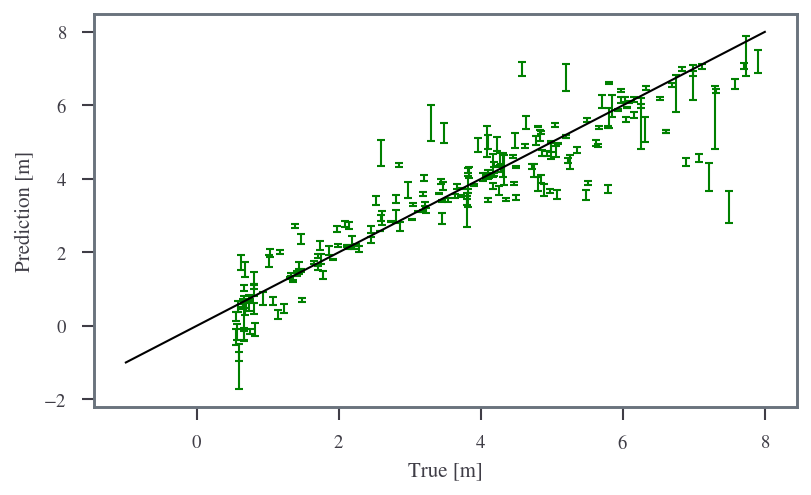

In [170]:
plt.errorbar(
    hold_out_y,
    y_pred_a[:, :, 0].mean(axis=0),
    yerr=y_pred_a[:, :, 0].std(axis=0),
    fmt="x",
    marker="x",
    mfc="red",
    ms=10,
    ecolor="green",
    capsize=2,
    capthick=1,
)

plt.plot([-1, 8], [-1, 8], color="black")
plt.xlabel("True [m]")
plt.ylabel("Prediction [m]")

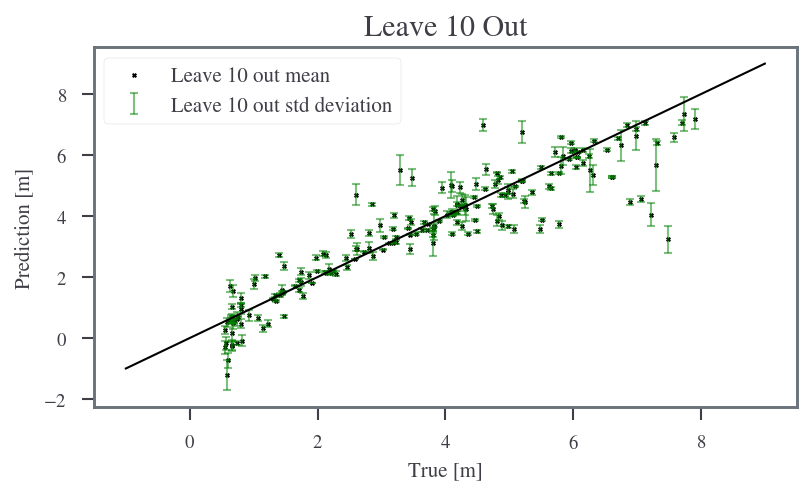

In [171]:
plt.errorbar(
    hold_out_y,
    y_pred_a[:, :, 0].mean(axis=0),
    yerr=y_pred_a[:, :, 0].std(axis=0),
    linestyle="",
    alpha=0.5,
    ecolor="green",
    capsize=2,
    capthick=1,
    label="Leave 10 out std deviation",
)


plt.scatter(
    hold_out_y,
    y_pred_a[:, :, 0].mean(axis=0),
    marker="x",
    s=3,
    color="black",
    label="Leave 10 out mean",
)

plt.plot([-1, 9], [-1, 9], color="black")
plt.xlabel("True [m]")
plt.ylabel("Prediction [m]")
plt.title("Leave 10 Out")

plt.legend()

In [172]:
def leave_n_out(kernel=Matern32, size: int = 350) -> None:
    y_pred_l = []
    for seed in range(0, 100):
        y_pred_l.append(y_pred_f(kernel=Matern32, seed=seed, size=size))
    y_pred_a = np.array(y_pred_l)

    plt.errorbar(
        hold_out_y,
        y_pred_a[:, :, 0].mean(axis=0),
        yerr=y_pred_a[:, :, 0].std(axis=0),
        linestyle="",
        alpha=0.5,
        ecolor="green",
        capsize=2,
        capthick=1,
        label="Leave Some out std deviation",
    )

    plt.scatter(
        hold_out_y,
        y_pred_a[:, :, 0].mean(axis=0),
        marker="x",
        s=3,
        color="black",
        label="Leave Some out mean",
    )

    plt.plot([-1, 9], [-1, 9], color="black")
    plt.xlabel("True [m]")
    plt.ylabel("Prediction [m]")
    plt.title("Leave Some Out")

    plt.legend()

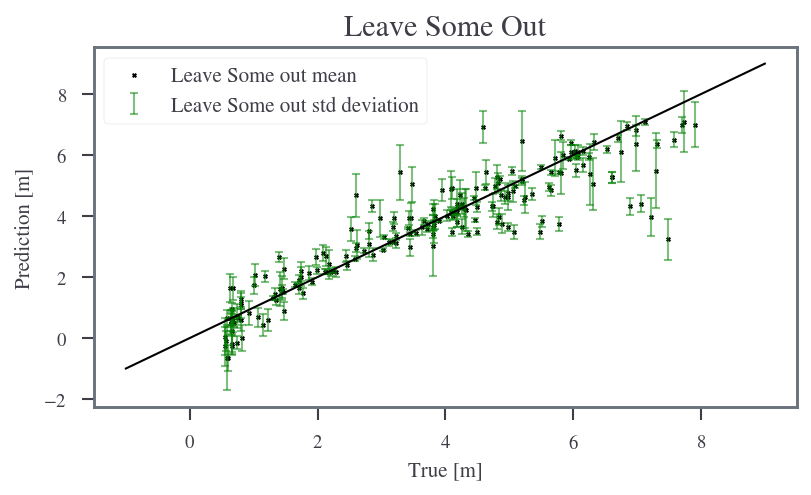

In [173]:
leave_n_out()

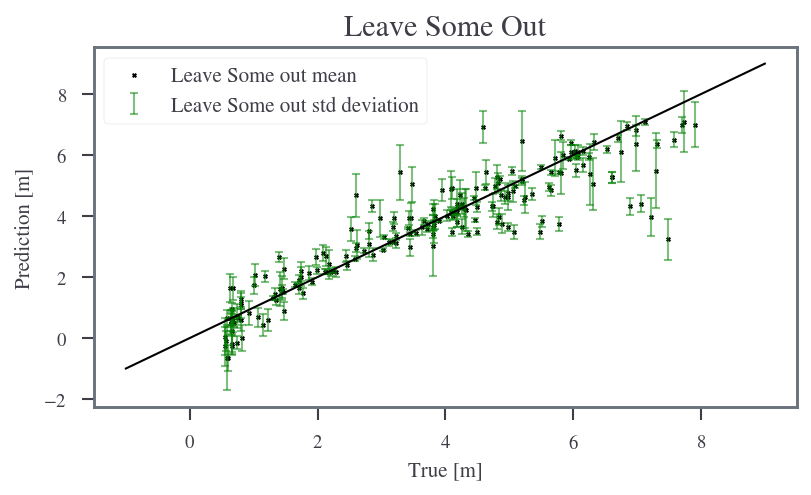

In [174]:
leave_n_out(kernel=RBF, size=350)

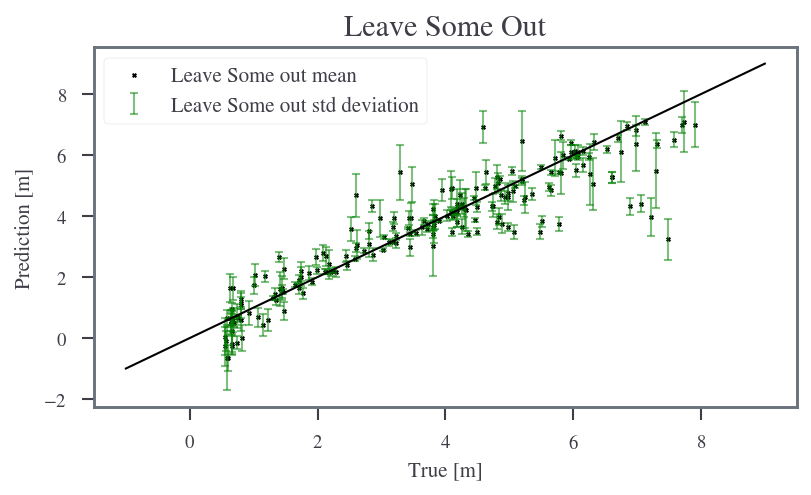

In [175]:
leave_n_out(kernel=Matern52, size=350)

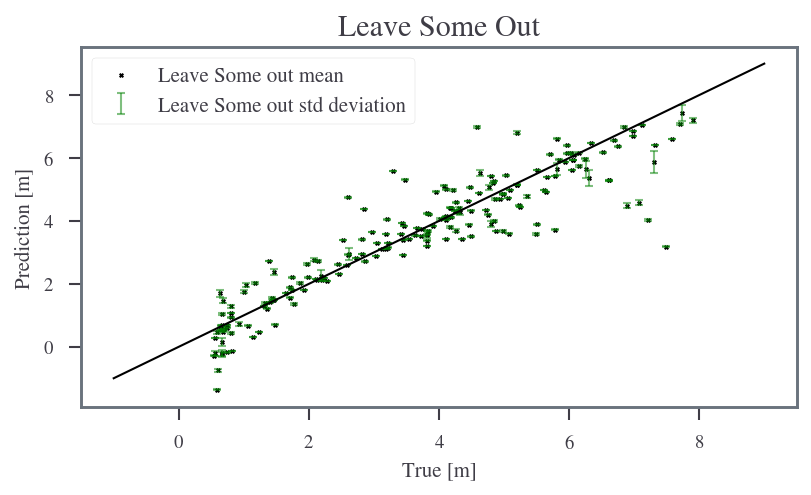

In [176]:
leave_n_out(kernel=Matern32, size=399)

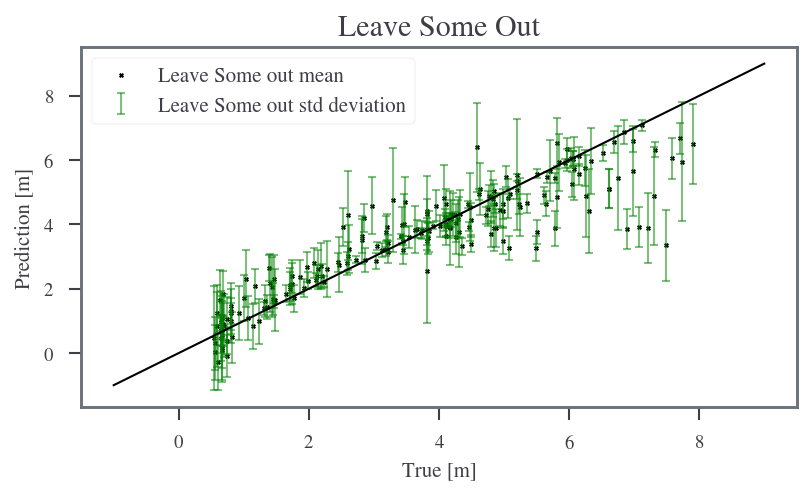

In [177]:
leave_n_out(kernel=Matern32, size=250)

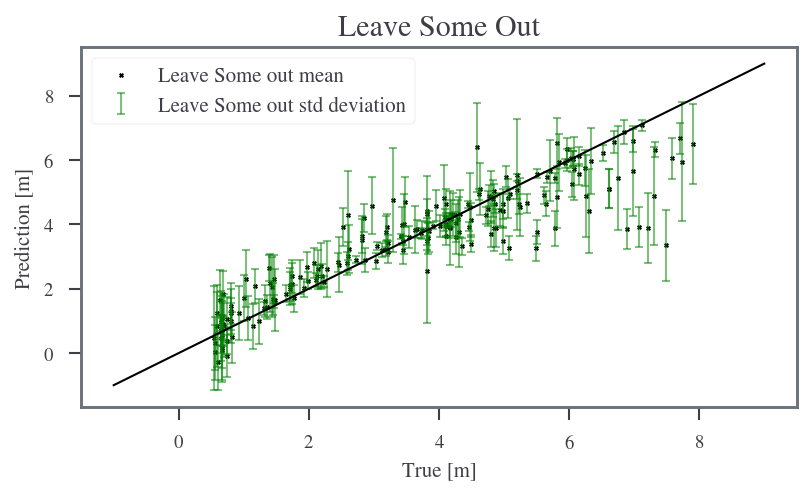

In [178]:
leave_n_out(kernel=RBF, size=250)

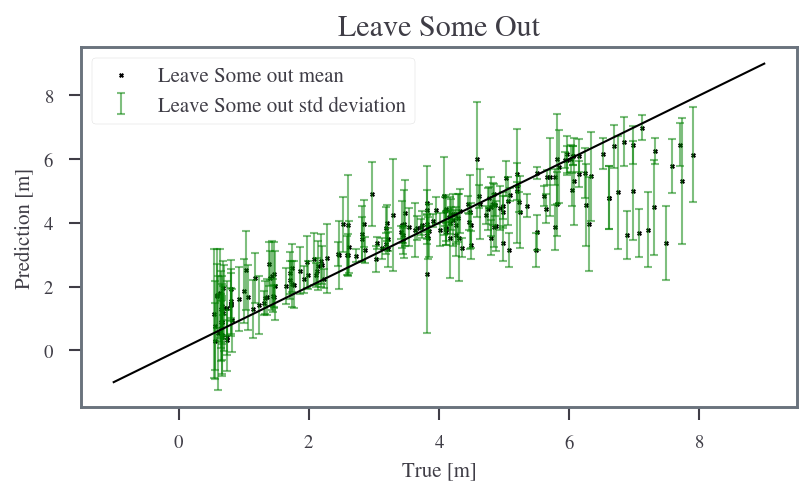

In [179]:
leave_n_out(kernel=Matern32, size=200)

Text(0, 0.5, 'Prediction [m]')

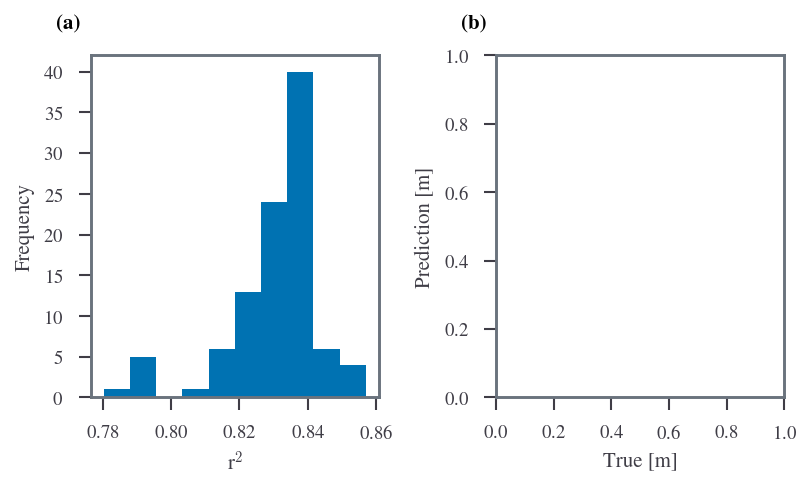

In [180]:
fig, axs = plt.subplots(1, 2)
label_subplots(axs, override="outside")
axs[0].hist(r2_list)
axs[0].set_xlabel("r$^{2}$")
axs[0].set_ylabel("Frequency")
axs[1].set_xlabel("True [m]")
axs[1].set_ylabel("Prediction [m]")

In [191]:
def leave_out(kernel=Matern32, size: int = 399) -> None:
    y_pred_l = []
    r2_list = []
    rmse_list = []
    for seed in range(0, 100):
        y_pre = y_pred_f(kernel=Matern32, seed=seed, size=size)
        r2_list.append(r2_score(hold_out_y, y_pre))
        rmse_list.append(np.sqrt(mean_squared_error(hold_out_y, y_pre)))
        y_pred_l.append(y_pre)
    y_pred_a = np.array(y_pred_l)

    fig, axs = plt.subplots(1, 2)
    label_subplots(axs, override="outside")

    axs[0].hist(r2_list)
    axs[0].set_xlabel("r$^{2}$")
    axs[0].set_ylabel("Frequency")

    axs[1].errorbar(
        hold_out_y,
        y_pred_a[:, :, 0].mean(axis=0),
        yerr=y_pred_a[:, :, 0].std(axis=0),
        linestyle="",
        alpha=0.5,
        ecolor="green",
        capsize=2,
        capthick=1,
        label="Std. dev.",
    )

    axs[1].scatter(
        hold_out_y,
        y_pred_a[:, :, 0].mean(axis=0),
        marker="x",
        s=3,
        color="black",
        label="Mean",
    )

    axs[1].plot([-1, 9], [-1, 9], color="black")
    axs[1].set_xlabel("True [m]")
    axs[1].set_ylabel("Prediction [m]")
    print(f"Mean r2: {np.mean(r2_list)}")
    print(f"Std. dev. r2: {np.std(r2_list)}")
    print(f"Mean rmse: {np.mean(rmse_list)}")
    print(f"Std. dev. rmse: {np.std(rmse_list)}")
    # axs[1].set_title("Leave Some Out")

    plt.legend()

Mean r2: 0.8366405097281419
Std. dev. r2: 0.004944035593459345
Mean rmse: 0.8161405126296266
Std. dev. rmse: 0.011774916811117666


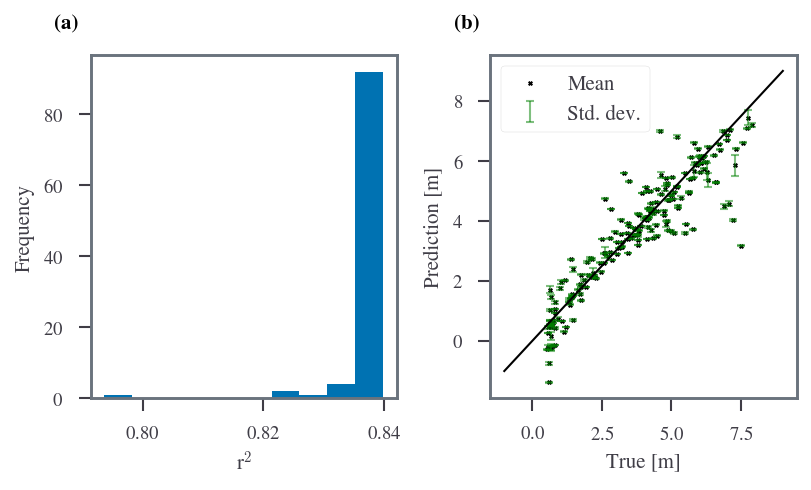

In [192]:
leave_out(kernel=Matern32, size=399)

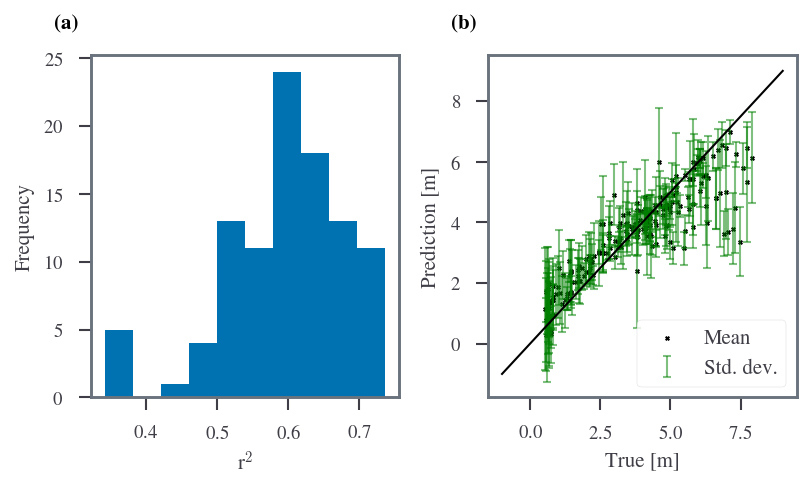

In [183]:
leave_out(kernel=Matern32, size=200)

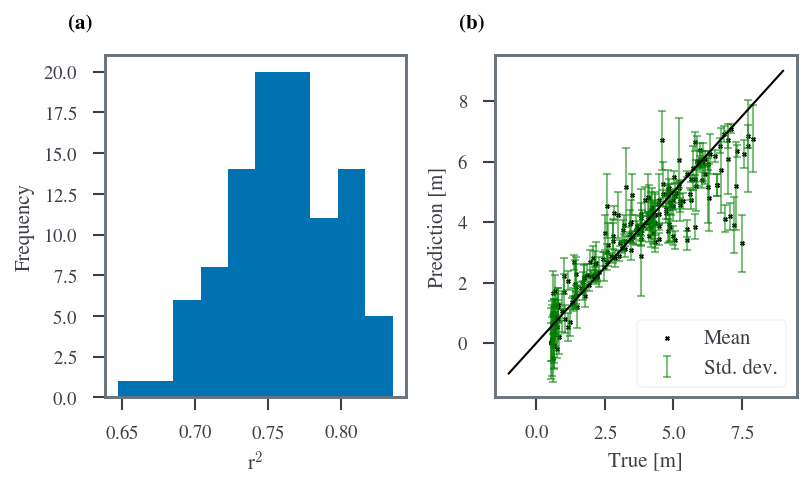

In [184]:
leave_out(kernel=Matern32, size=300)

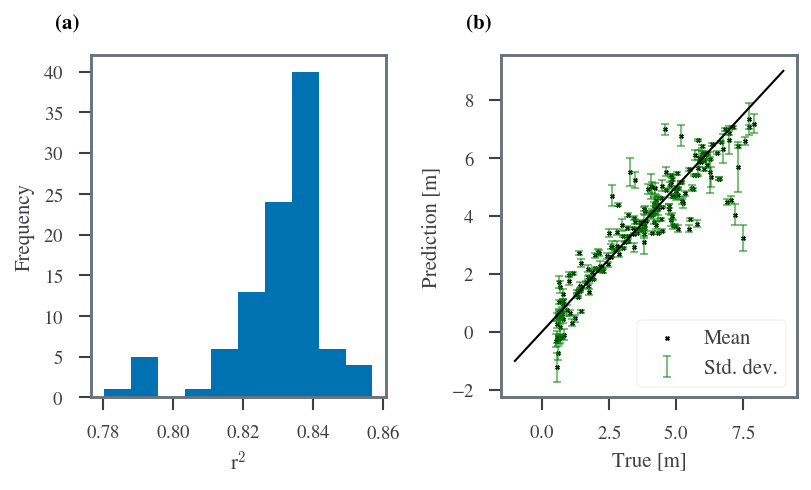

In [185]:
leave_out(kernel=Matern32, size=390)

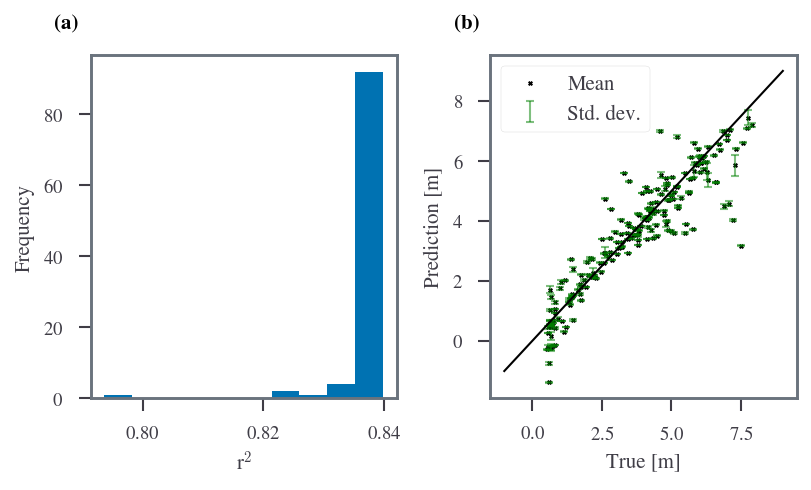

In [186]:
leave_out(kernel=Matern32, size=399)

In [187]:
def leave_out_range(kernel=Matern32, size: int = 399) -> None:
    y_pred_l = []
    r2_list = []
    for seed in range(0, 100):
        y_pre = y_pred_f(kernel=Matern32, seed=seed, size=size)
        r2_list.append(r2_score(hold_out_y, y_pre))
        y_pred_l.append(y_pre)
    y_pred_a = np.array(y_pred_l)

    fig, axs = plt.subplots(1, 2)
    label_subplots(axs, override="outside")

    axs[0].hist(r2_list)
    axs[0].set_xlabel("r$^{2}$")
    axs[0].set_ylabel("Frequency")

    mins = y_pred_a[:, :, 0].min(axis=0)
    maxs = y_pred_a[:, :, 0].max(axis=0)
    mids = (mins + maxs) / 2
    half_ranges = (mins - maxs) / 2

    axs[1].errorbar(
        hold_out_y,
        mids,
        yerr=half_ranges,
        linestyle="",
        alpha=0.5,
        ecolor="red",
        capsize=2,
        capthick=1,
        label="Range",
    )

    axs[1].errorbar(
        hold_out_y,
        y_pred_a[:, :, 0].mean(axis=0),
        yerr=y_pred_a[:, :, 0].std(axis=0),
        linestyle="",
        alpha=0.5,
        ecolor="green",
        capsize=2,
        capthick=1,
        label="Std. dev.",
    )

    axs[1].scatter(
        hold_out_y,
        y_pred_a[:, :, 0].mean(axis=0),
        marker="x",
        s=3,
        color="black",
        label="Mean",
    )

    axs[1].plot([-1, 9], [-1, 9], color="black")
    axs[1].set_xlabel("True [m]")
    axs[1].set_ylabel("Prediction [m]")
    # axs[1].set_title("Leave Some Out")

    plt.legend()

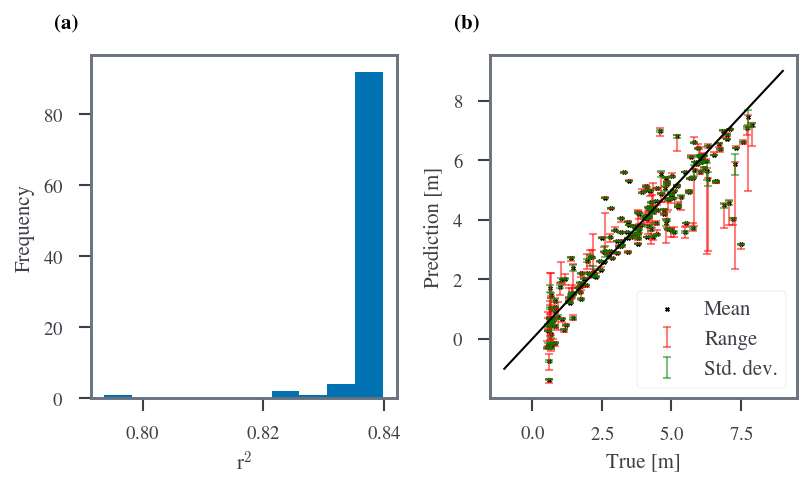

In [188]:
leave_out_range(kernel=Matern32, size=399)

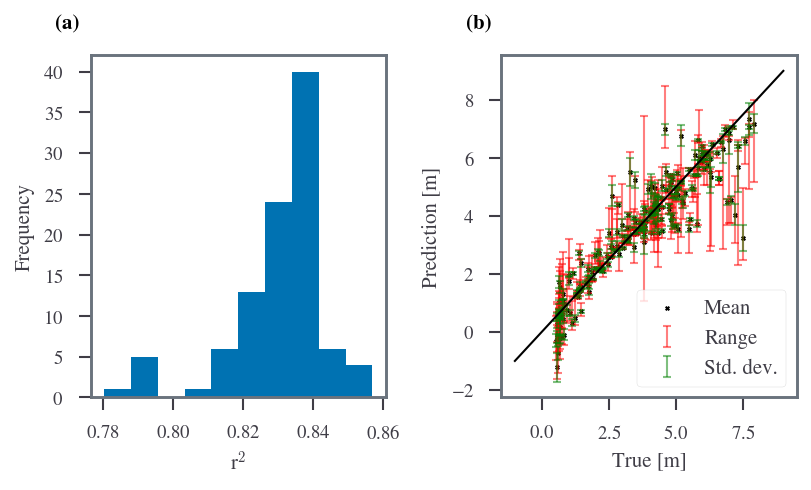

In [189]:
leave_out_range(kernel=Matern32, size=390)

In [190]:
leave_out_range(kernel=Matern32, size=300)

KeyboardInterrupt caught, calling on_optimization_end() to round things up


KeyboardInterrupt: 

In [ ]:
leave_out_range(kernel=Matern32, size=200)

In [ ]:
leave_out_range(kernel=RBF, size=390)

In [ ]:
leave_out_range(kernel=RBF, size=350)